In [1]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")
colors = sns.color_palette("Set1")
sns.set_style('ticks')

In [2]:
def get_paths(relative_dir = "results/weighted/"):
    paths = os.listdir("../" + relative_dir)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store' or paths[i] == 'archive'):
            rel_paths.append(relative_dir + paths[i])
    return rel_paths

In [14]:
def find_policy_name(path):
    string = path.split("_")[2]
    if string == 'susceptible':
        return "Population-Based"
    if string == 'infection':
        return "Infection-Based"
    if string == 'random':
        return "Random"
    if string == 'oldest':
        return "Age-Based"
    if string == 'contact':
        return "Contact-Based"
    if string == 'fhi':
        return "NIPH"
    return "ETP"

In [15]:
paths = get_paths()
results = {}
counter=1
for relative_path in paths:
    key = find_policy_name(relative_path)
    if key=="ETP":
        key += f" nr. {counter}"
        counter += 1
    results[key] = utils.read_csv(relative_path=relative_path)

Reading results from ['weighted', '2021', '06', '05', '14', '56', '07'] ..
100%|██████████| 500/500 [00:06<00:00, 72.97it/s]
Reading results from ['weighted', '2021', '06', '05', '14', '52', '47'] ..
100%|██████████| 500/500 [00:07<00:00, 70.96it/s]
Reading results from ['weighted', '2021', '06', '05', '14', '52', '43'] ..
100%|██████████| 500/500 [00:06<00:00, 72.22it/s]


In [16]:
nr_sim = results[list(results.keys())[0]][4].shape[0]
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros((nr_sim,5)) #axis 1: index 0: deaths, 1: infected, 2: yll, 3: vaccinated, 4: weighted

In [17]:
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)

for key in list(results.keys()):
    print("Finding objective values for ", key)
    result = results[key]
    age_labels = result[0]
    
    new_deaths_age_groups = result[-3]
    cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
    cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
    yll = np.zeros((cumulative_deaths.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        cum_deaths[i] = cumulative_deaths[i,-1,:]
        yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
    deaths = np.sum(cum_deaths, axis=1)

    new_infected_age_groups = result[-4]
    cumulative_infected = new_infected_age_groups.cumsum(axis=1)
    infected = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_infected.shape[0]):
        infected[i] = np.sum(cumulative_infected[i,-1,:])

    vaccinated_age_groups = result[-2]
    vaccinated = np.zeros((vaccinated_age_groups.shape[0]))
    for i in range(vaccinated_age_groups.shape[0]):
        vaccinated[i] = np.sum(vaccinated_age_groups[i,-1,:])

    weighted = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        weighted[i] = 0.01*infected[i] + deaths[i]
        

    objective_values[key][:,0] = deaths
    objective_values[key][:,1] = infected
    objective_values[key][:,2] = yll
    objective_values[key][:,3] = vaccinated
    objective_values[key][:,4] = weighted

Finding objective values for  ETP nr. 1
Finding objective values for  ETP nr. 2
Finding objective values for  ETP nr. 3


In [18]:
def density_plot(values, key, color):
    # Draw the density plot
    ax = sns.distplot(values, hist=False, kde=True,
                 kde_kws={'linewidth': 1.5},
                 label=key, color=color)
    ax.set(yticklabels=[])
    ax.set(xlabel=None, ylabel=None)
    return ax

Deaths

Infected

YLL

Weighted



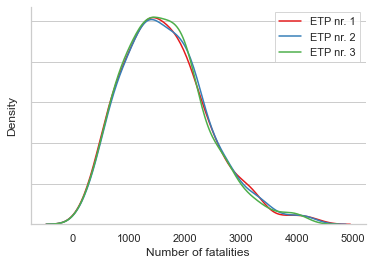

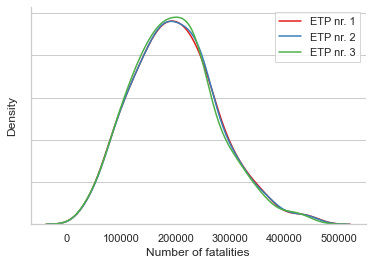

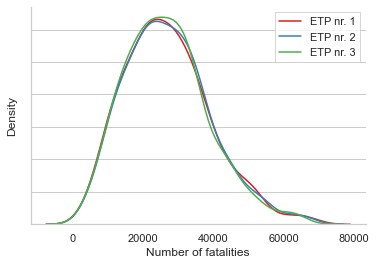

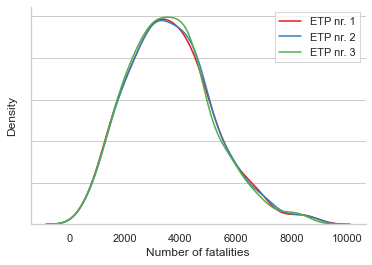

In [31]:
keys = list(results.keys())
print("Deaths")
print()
plt.figure()
for n in range(len(keys)):
    ax = density_plot(objective_values[keys[n]][:,0], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_distributions.png", dpi=200)

print("Infected")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,1], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_infected_distributions.png", dpi=200)


print("YLL")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,2], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_yll_distributions.png", dpi=200)

print("Weighted")
print()
plt.figure()
for n in range(len(keys)): 
    ax = density_plot(objective_values[keys[n]][:,4], keys[n], colors[n])
plt.legend(loc='upper right', ncol=1, fancybox=False, shadow=False)
plt.xlabel('Number of fatalities')
plt.ylabel("Density")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax.xaxis.grid()
plt.savefig("../plots/computational_study/weighted_significance/random_weighted_distributions.png", dpi=200)

In [32]:
def t_test(first, second):
        """ Performs one-sided t-test to check to variables for significant difference

        Args:
            first (Individual): presumed best individual
            second (Individual): presumed worse individual
            significance (float, optional): level of significance to test against. Defaults to 0.1.

        Returns:
            bool: True if significance is achieved
        """
        if not (first==second).all():
            z = first - second
            return scipy.stats.ttest_ind(z, np.zeros(len(first)), alternative="less").pvalue
        return 1

In [33]:
dead = dict(map(lambda x: (x[0], np.array(x[1])[:,0]), objective_values.items()))
infected = dict(map(lambda x: (x[0], np.array(x[1])[:,1]), objective_values.items()))
yll = dict(map(lambda x: (x[0], np.array(x[1])[:,2]), objective_values.items()))
vaccinated = dict(map(lambda x: (x[0], np.array(x[1])[:,3]), objective_values.items()))
weighted = dict(map(lambda x: (x[0], np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1]), objective_values.items()))

mean_dead = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0])), objective_values.items()))
mean_infected = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,1])), objective_values.items()))
mean_yll = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,2])), objective_values.items()))
mean_vaccinated = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,3])), objective_values.items()))
mean_weighted = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))

sorted_dead = dict(sorted(mean_dead.items(), key=lambda x: x[1]))
sorted_infected = dict(sorted(mean_infected.items(), key=lambda x: x[1]))
sorted_yll = dict(sorted(mean_yll.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_vaccinated.items(), key=lambda x: x[1]))
sorted_weighted = dict(sorted(mean_weighted.items(), key=lambda x: x[1]))
 
std_dead = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0])), objective_values.items()))
std_infected = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,1])), objective_values.items()))
std_yll = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,2])), objective_values.items()))
std_vaccinated = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,3])), objective_values.items()))
std_weighted = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0] + 0.01*np.array(x[1])[:,1])), objective_values.items()))


In [34]:
print()
print("Dead")
keys = list(sorted_dead.keys())
for key in keys:
    print(f"{key:>20} {mean_dead[key]:>8,.0f} {std_dead[key]:>8,.0f} {std_dead[key]/mean_dead[key]:>8,.2f}")
print()
print()
print("Infected")
for key in keys:
    print(f"{key:>20} {mean_infected[key]:>8,.0f} {std_infected[key]:>8,.0f} {std_infected[key]/mean_infected[key]:>8,.2f}")
print()
print()
print("YLL")
for key in keys:
    print(f"{key:>20} {mean_yll[key]:>8,.0f} {std_yll[key]:>8,.0f} {std_yll[key]/mean_yll[key]:>8,.2f}")
print()
print()
print("Vaccinated")
for key in keys:
    print(f"{key:>20} {mean_vaccinated[key]:>8,.0f} {std_vaccinated[key]:>8,.0f} {std_vaccinated[key]/mean_vaccinated[key]:>8,.2f}")

print()
print()
print("Weighted Objective")
for key in keys:
    print(f"{key:>20} {mean_weighted[key]:>8,.0f} {std_weighted[key]:>8,.0f} {std_weighted[key]/mean_weighted[key]:>8,.2f}")


Dead
           ETP nr. 3    1,639      748     0.46
           ETP nr. 1    1,653      767     0.46
           ETP nr. 2    1,665      763     0.46


Infected
           ETP nr. 3  197,588   78,093     0.40
           ETP nr. 1  199,979   79,627     0.40
           ETP nr. 2  200,045   79,290     0.40


YLL
           ETP nr. 3   26,777   11,881     0.44
           ETP nr. 1   27,104   12,212     0.45
           ETP nr. 2   27,257   12,140     0.45


Vaccinated
           ETP nr. 3 2,323,586   59,526     0.03
           ETP nr. 1 2,287,335   64,651     0.03
           ETP nr. 2 2,346,282   40,805     0.02


Weighted Objective
           ETP nr. 3    3,615    1,526     0.42
           ETP nr. 1    3,652    1,560     0.43
           ETP nr. 2    3,665    1,553     0.42


In [35]:
solution1 = 0
solution2 = 1

print("solution 1", list(sorted_dead.keys())[solution1])
print("solution 2", list(sorted_dead.keys())[solution2])

solution 1 ETP nr. 3
solution 2 ETP nr. 1


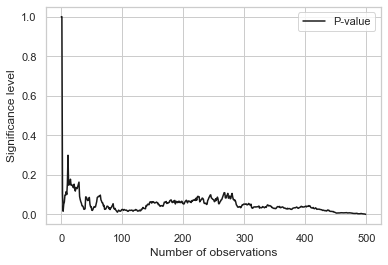

In [36]:

objective_value_best = objective_values[list(sorted_dead.keys())[solution1]][:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[solution2]][:,0]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_significance.png", dpi=200)

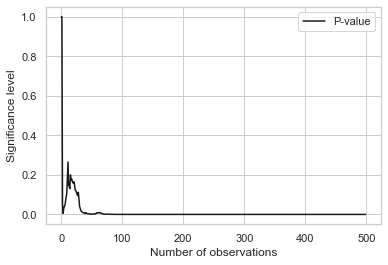

In [37]:
objective_value_best = objective_values[list(sorted_infected.keys())[solution1]][:,1]
objective_value_second_best = objective_values[list(sorted_infected.keys())[solution2]][:,1]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_infected_significance.png", dpi=200)

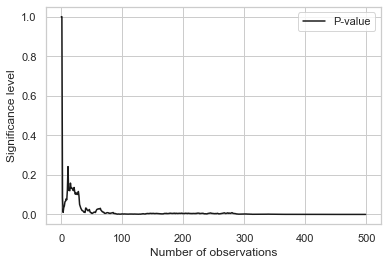

In [38]:
objective_value_best = objective_values[list(sorted_yll.keys())[solution1]][:,2]
objective_value_second_best = objective_values[list(sorted_yll.keys())[solution2]][:,2]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_yll_significance.png", dpi=200)

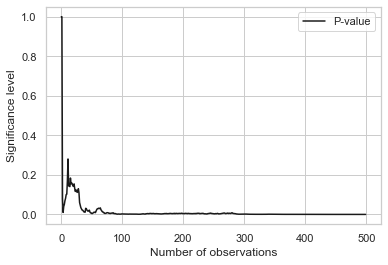

In [39]:
objective_value_best = objective_values[list(sorted_weighted.keys())[solution1]][:,4]
objective_value_second_best = objective_values[list(sorted_weighted.keys())[solution2]][:,4]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value", color='k')
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_weighted_significance.png", dpi=200)

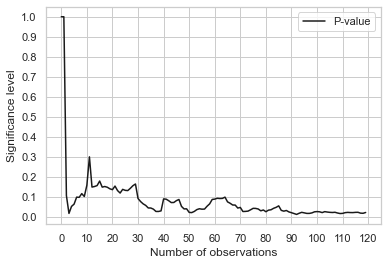

In [40]:
objective_value_best = objective_values[list(sorted_dead.keys())[solution1]][:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[solution2]][:,0]

p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations[:120], p_values[:120], label="P-value", color='k')
plt.xticks(observations[0:121:10])
plt.yticks([0.1*i for i in range(11)])
plt.xlabel("Number of observations")
plt.ylabel("Significance level")
plt.savefig("../plots/computational_study/weighted_significance/random_fatalities_significance_narrowed.png", dpi=200)

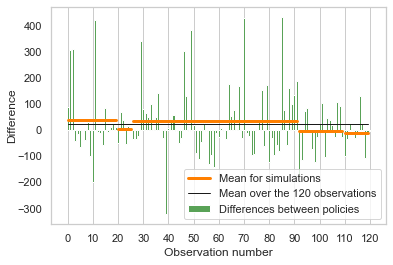

In [41]:
observations = np.arange(len(objective_value_best))
diffs = np.arange(len(objective_value_best))
for i in range( len(objective_value_best)-1):
   diffs[i] = objective_value_second_best[i] - objective_value_best[i]

l1 = 20  #limit 1
l2 = 26  #limit 2
l3 = 92  #limit 3
l4 = 110  #limit 4
l5 = 120  #limit 5

sns.set()
sns.set_style("whitegrid")
ax = sns.barplot(observations[:l5+1], diffs[:l5+1], label = "Differences between policies", color=colors[2], dodge=False)
sns.lineplot(observations[:l1], np.mean(diffs[:l1]), label = "Mean for simulations", linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l1:l2], np.mean(diffs[l1:l2]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l2:l3], np.mean(diffs[l2:l3]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l3:l4], np.mean(diffs[l3:l4]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[l4:l5], np.mean(diffs[l4:l5]), linewidth=3, color=colors[4], ax=ax)
sns.lineplot(observations[:l5], np.mean(diffs[:l5]), label = f"Mean over the {l5} observations", linewidth=1, color='k', ax=ax)
plt.xticks(observations[:l5+1:10])
plt.xlabel("Observation number")
plt.grid()
ax.set_ylabel("Difference", labelpad=0)
plt.savefig("../plots/computational_study/weighted_significance/fatalities_diffs.png", dpi=200)

In [42]:
np.mean(diffs[:l5])

23.191666666666666